# Introdução

Neste notebook faremos um estudo com base em um banco de dados de playlists criadas, entre janeiro de 2010 e outubro de 2017, pelos usuários do Spotify. Por meio do banco de dados, iremos construir uma rede de coocorrência de artistas, onde um vértice representa um artista e uma aresta é adicionada entre dois artista se os mesmos se encontram na mesma playlist. Sabendo disso faremos um estudo por meio das métricas já implementadas na biblioteca Networkx. Abaixo importamos alguns pacotes para que possamos fazer as manipulações dos dados e para gerar gráficos e também fazer os nossos estudos por meio das métricas.

[link]("https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge") para a base dados.

In [ ]:
!pip install networkx==2.6.2

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import json
import seaborn as sns

In [ ]:
!wget --no-check-certificate "https://raw.githubusercontent.com/Kaioh95/Spotify-Artists-Network/main/data/mpd.slice.0-999.json"
path = "mpd.slice.0-999.json"
d = json.load(open(path, "r"))
thisSlice = pd.DataFrame.from_dict(d["playlists"], orient="columns")

--2022-01-14 15:07:42--  https://raw.githubusercontent.com/Kaioh95/Spotify-Artists-Network/main/data/mpd.slice.0-999.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34119368 (33M) [text/plain]
Saving to: ‘mpd.slice.0-999.json’

mpd.slice.0-999.jso 100%[===================>]  32.54M  --.-KB/s    in 0.1s    

2022-01-14 15:07:44 (275 MB/s) - ‘mpd.slice.0-999.json’ saved [34119368/34119368]



In [ ]:
# Parte do código tirada de: 
# https://github.com/vaslnk/Spotify-Song-Recommendation-ML/blob/master/EDA.ipynb 
songPlaylistArray = []

for index, row in thisSlice.iterrows():
    for track in row["tracks"]:
        if(track["artist_name"].endswith("$$")):
            songPlaylistArray.append([track["artist_name"].replace("$$", "SS"), track["track_name"], row["pid"]])
            continue
        songPlaylistArray.append([track["artist_name"], track["track_name"], row["pid"]])
songPlaylist = pd.DataFrame(songPlaylistArray, columns=["artist_name", "track_name", "pid"])

print(songPlaylist.shape)
songPlaylist.head(10)

(67503, 3)


,artist_name,track_name,pid
0,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),0
1,Britney Spears,Toxic,0
2,Beyoncé,Crazy In Love,0
3,Justin Timberlake,Rock Your Body,0
4,Shaggy,It Wasn't Me,0
5,Usher,Yeah!,0
6,Usher,My Boo,0
7,The Pussycat Dolls,Buttons,0
8,Destiny's Child,Say My Name,0
9,OutKast,Hey Ya! - Radio Mix / Club Mix,0


# Construindo a Rede

Ao selecionar um slice do dataset, que originalmente estava no formato json, precisamos ler os dados corretamente e então depois transformá-los em um DataFrame do Pandas. Dessa forma, facilitamos a leitura dos dados para que possamos construir a rede. Agora, fazemos um laço (for) passando pelo id de cada playlist e utilizamos o dados apenas das primeiras 500 playlists, dado um id de uma playlist selecionamos todas a linhas com o atributo **pid** igual ao id atual do laço. Com isso, adicionamos uma aresta entre cada cada artista presente em uma determinada playlist e depois continuamos o processo para cada playlist. Ao final do processo, temos uma rede representada por um grafo do Networkx.

In [ ]:
g = nx.Graph()

for pid in songPlaylist["pid"].unique():
  if(pid < 500):
    playlist = songPlaylist.loc[songPlaylist["pid"] == pid]
    art_list = []
    for index, row in playlist.iterrows():
        art_list.append(row["artist_name"])

    art_series = pd.Series(art_list)
    art_uniq = art_series.unique()

    for ii in range(0, len(art_uniq)):
        for jj in range(ii+1, len(art_uniq)):
            if(g.has_edge(art_uniq[ii], art_uniq[jj])):
                g[art_uniq[ii]][art_uniq[jj]]["weight"] += 1
            else:
                g.add_edge(art_uniq[ii], art_uniq[jj], weight = 1)

    for key, value in art_series.value_counts().to_dict().items():
        if(value > 1):
            if(g.has_edge(key, key)):
                g[key][key]["weight"] += value
            else:
                g.add_edge(key, key, weight = value-1)


In [ ]:
import copy
original = copy.copy(g)

Observe que agora nossa rede tem ```6514 vértices``` e ```478955 arestas```. Porém, ainda precisamos nos preocupar com a limpeza dessa rede, logo vamos remover laços e possíveis vértices duplicados.

In [ ]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

6514 nodes, 478955 edges


In [ ]:
g.remove_edges_from(nx.selfloop_edges(g))

In [ ]:
# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s") 
              for node in g if node + "s" in g
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(g, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in 
              [(node, node.replace("-", " ")) for node in g]
                if x != y and y in g]
print(duplicates)

for dup in duplicates:
  g = nx.contracted_nodes(g, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(g, 0,"contraction")
nx.set_edge_attributes(g, 0,"contraction")

[('Bas', 'Bass'), ('Alpine', 'Alpines'), ('France', 'Frances')]
[]


Ao final da eliminação de duplicatas e de laços, reduzimos o número de vértices de ```6514``` para ```6511``` e ```478955 arestas``` para ```476857 arestas```.

In [ ]:
  print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

6511 nodes, 476857 edges


# Eccentricity
Excentricidade de um vértice de uma rede é valor da distância do maior dos menores caminhos do vértice com relação ao outros vértices de uma rede.

Apesar da lista dos Top 10 artistas com maior excentricidade, há muito mais artistas com excentricidade igual 6, logo listar apenas 10 não faz muito sentido.

In [ ]:
largest_cc = max(nx.connected_components(g), key=len)
g_aux = nx.subgraph(g, largest_cc)

In [ ]:
eccentricityDict = nx.eccentricity(g_aux)

In [ ]:
eccentricityArray = []

for key, value in dict(eccentricityDict).items():
    eccentricityArray.append([key, value])
eccentricityDF = pd.DataFrame(eccentricityArray, columns=["artist_name", "eccentricity"])

eccentricityDF = eccentricityDF.sort_values(by="eccentricity", ascending=False)
eccentricityDF.head(10)

,artist_name,eccentricity
3613,Lullaby Land,6
4273,Hijos De Barron,6
4280,El Bebeto,6
4279,Los Rojos,6
4278,Buknas De Culiacan,6
4277,Martin Castillo,6
4276,Banda Carnaval,6
4275,Grupo Maximo Grado,6
4274,Fuerza de Tijuana,6
4272,Los Plebes del Rancho de Ariel Camacho,6


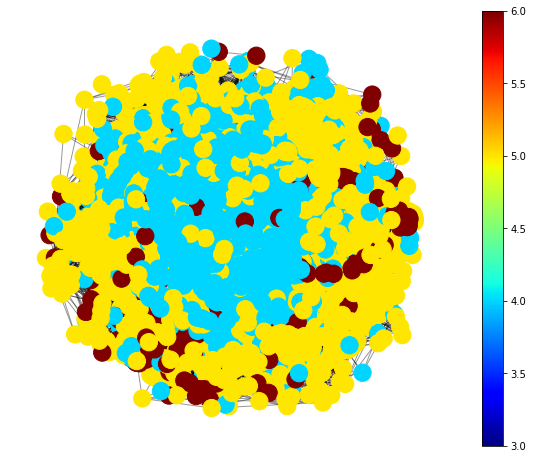

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

pos = nx.spring_layout(g_aux, seed=12345679, k=0.3)
color = list(dict(eccentricityDict).values())

nx.draw_networkx_edges(g_aux, 
                       pos=pos, 
                       alpha=0.4, 
                       ax=ax)

nodes = nx.draw_networkx_nodes(g_aux, 
                               pos=pos, 
                               node_color=color, 
                               cmap=plt.cm.jet, 
                               ax=ax)

#nx.draw_networkx_labels(g_eccentricityTop, pos=pos, font_color="black", ax=ax)

plt.axis("off")
plt.colorbar(nodes)
plt.savefig("eccentricity.png", transparent=True, dpi=300)
plt.show()

# Diameter
O **diâmetro** de uma rede é o maior valor de excentricidade. 

In [ ]:
diameterN = nx.diameter(g_aux) 

In [ ]:
diameterN

6

# Periphery
Neste caso é mais interessante listar todos os artistas na periferia. Lembrando que a **periferia** de uma rede é um conjunto de vértices com a excentricidade igual ao diâmetro. 

In [ ]:
periphery = nx.periphery(g_aux)

In [ ]:
periphery

['Kelly Price',
 'Florida A&M University Gospel Choir',
 'Norman Hutchins',
 'Dottie Peoples & The Peoples Choice Chorale',
 'Tasha Cobbs Leonard',
 'Donald Lawrence',
 'Benita Washington',
 'The Warriors, DR.Charles G. Hayes',
 'The New Life Community Choir',
 'Donnie McClurkin',
 'Shekinah Glory Ministry',
 'Smokie Norful',
 'Tye Tribbett',
 'Richard Smallwood',
 'Tamela Mann',
 'The Rance Allen Group',
 'CeCe Winans',
 'J Moss',
 'Kurt Carr & The Kurt Carr Singers',
 'SISTAR',
 'Yu Jae Seok',
 'SEVENTEEN',
 'Agust D',
 '24K',
 'TWICE',
 'I.O.I',
 'Red Velvet',
 'GOT7',
 'Jon Schmidt',
 'Alex Goot',
 'Axel Hedfors',
 'Sia Furler',
 'Sergei Rachmaninoff',
 'Kathleen Edwards',
 'Emmylou Harris',
 'Sam Outlaw',
 'Jamie N Commons',
 'Warren Haynes',
 'Iris DeMent',
 'Allen Toussaint',
 'Sons Of Bill',
 'The Mavericks',
 'Lullaby Land',
 'Steven C',
 'Christopher M. Georges',
 'Worship Music Piano',
 'Klaus Kuehn',
 'Terri Geisel',
 'Kim Costanza',
 "The O'Neill Brothers Group",
 'Praise 

# Radius
Com definição complementar ao diâmetro, o **raio** de uma rede é o menor valor de excentricidade.

In [ ]:
radiusN = nx.radius(g_aux)

In [ ]:
radiusN

3

# Center
O centro de uma rede é um conjunto de vértices com excentricidade igual ao raio da rede. Veja abaixo o centro da nossa rede.

In [ ]:
centerList = nx.center(g_aux)

In [ ]:
centerList

["Destiny's Child",
 'OutKast',
 'Nelly Furtado',
 'Omarion',
 'Nicki Minaj',
 'Arctic Monkeys',
 'Oh Wonder',
 'Childish Gambino',
 'Cage The Elephant',
 'The Beatles',
 'alt-J',
 'Chance The Rapper',
 'Drake',
 'Russ',
 'Kendrick Lamar',
 'Ellie Goulding',
 'Kanye West',
 'Frank Ocean',
 'Mary Lambert',
 'Logic',
 'Sam Smith',
 'Khalid',
 'Alabama Shakes',
 'Snoop Dogg',
 'Tove Lo',
 'Foster The People',
 'Miike Snow']